In [461]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import re
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

In [462]:
files = !ls

In [463]:
files = [f for f in files if f.endswith('.CSV')]

In [464]:
def read_file(f):
    s = pd.read_csv(f, squeeze=True, header=None, names=['time', 'current'], index_col=['time'])
    s.index = np.round(s.index, decimals=3)
    return s

def tek_name(i):
    return "TEK000%02d.CSV" % i

In [465]:
good_series = {}
for i in range(4):
    name = tek_name(i)
    good_series[name] = read_file(name)

In [466]:
for s in good_series.values():
    s.index = np.round(s.index, decimals=3)

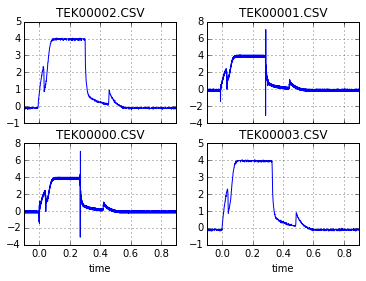

In [467]:
subplt = plt.subplots(2, 2)
for ax, (name, s) in zip(subplt[1].reshape((4, )), good_series.items()):
    s.plot(ax=ax, title = name)

In [468]:
bad_series = {}
for i in range(10, 18):
    name = tek_name(i)
    bad_series[name] = read_file(name)

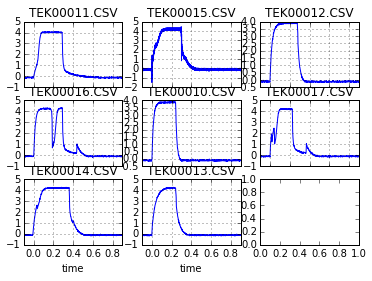

In [469]:
subplt = plt.subplots(3, 3)
for ax, (name, s) in zip(subplt[1].reshape((9, )), bad_series.items()):
    s.plot(ax=ax, title = name)

In [470]:
class SingleParamNormal(object):
    def __init__(self, mean, sigma, data_sigma):
        self.data_sigma = data_sigma
        self.mean = mean
        self.sigma = sigma
        
    def sample(self, num_samples=1):
        return np.random.normal(self.mean, self.data_sigma, num_samples)

    def update(self, new_point):
        ## assuming new data follows 
        self.mean += (new_point - self.mean) * (self.sigma**2) / (self.data_sigma**2 + self.sigma**2)
        self.sigma = np.sqrt((self.sigma**2 * self.data_sigma**2) / (self.data_sigma**2 + self.sigma**2))
        
    def sample_predictive(self, num_samples):
        return np.random.normal(self.mean, np.sqrt(self.sigma**2 + self.data_sigma**2))

    def prob(self, point):
        # what is the probability that the point belongs?
        p = stats.norm(self.mean, self.data_sigma)
#         print(p.pdf(point), end = "/")
        return p.pdf(point)


class NormalChain(object):
    def __init__(self, n, priors=(0, 1), data_sigma=1, tag="good"):
        self.num_links = n
        self.nodes = [SingleParamNormal(priors[0], priors[1], data_sigma) for _ in range(n - 1)]
        self.tag = tag
        
    def update(self, arr):
        # arr is of length n; take diffs, which is of length n - 1
        diffs = np.diff(arr)
        for node, point in zip(self.nodes, diffs):
            node.update(point)
    
    def sample_path(self):
        new_diffs = np.array([node.sample() for node in self.nodes], dtype=np.float)
        return pd.Series(data=np.cumsum(new_diffs))
        
    def log_likelihood(self, new_data):
        # given new_data, what is the probability that it fits here?
        diffs = np.diff(new_data)
        return sum(filter(lambda x: x > 1e-30, [np.log(node.prob(v)) for node, v in zip(self.nodes, diffs)]))
    
class Predictor(object):
    def __init__(self, **kwargs):
        self.chains = kwargs
        
    def predict(self, series):
        ll = {name: chain.log_likelihood(series) for name, chain in self.chains.items()}
        return reduce(lambda x, y: x if ll[x] > ll[y] else y, ll.keys())

In [471]:
def transform(s):
    return pd.rolling_mean(s, 10).iloc[9::10] * 10
#     return pd.rolling_mean(s, 10).iloc[400:] * 10
#     return pd.rolling_mean(s, 10).iloc[9:]
#     return s

# idx = transform(good_series[tek_name(0)]).index

chain = NormalChain(99, priors=(0, 0.01), data_sigma = 0.01)
chain.update(transform(good_series[tek_name(0)]))
chain.update(transform(good_series[tek_name(1)]))
chain.update(transform(good_series[tek_name(2)]))
chain.update(transform(good_series[tek_name(3)]))

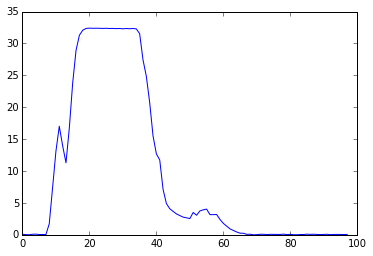

In [509]:
paths = np.array([chain.sample_path() for _ in range(1000)])
paths.mean(axis=0)
plt.plot(paths.mean(axis=0))

In [473]:
for i in range(4):
    print(i, chain.log_likelihood(transform(good_series[tek_name(i)])))

0 57.4420229724
1 49.0721697501
2 25.0223165278
3 31.4347798334


In [474]:
for i in range(10, 18):
    print(i, chain.log_likelihood(transform(bad_series[tek_name(i)])))

10 16.3698532223
11 15.8711582639
12 22.1423165278
13 18.7760848751
14 29.5147798334
15 49.4046330557
16 19.5698532223
17 26.4560848751


In [475]:
np.var(transform(good_series[tek_name(0)]).diff())

9.8514740944801567

In [476]:
s = good_series[tek_name(1)]

In [320]:
pd.rolling_mean(s, 10).iloc[9::10]

time
-0.091   -0.120
-0.081   -0.112
-0.071   -0.112
-0.061   -0.116
-0.051   -0.108
-0.041   -0.120
-0.031   -0.116
-0.021   -0.116
-0.011   -0.112
-0.001    0.280
 0.009    1.164
 0.019    1.776
 0.029    2.188
 0.039    1.044
 0.049    1.516
...
0.759   -0.108
0.769   -0.112
0.779   -0.120
0.789   -0.112
0.799   -0.116
0.809   -0.108
0.819   -0.112
0.829   -0.112
0.839   -0.116
0.849   -0.116
0.859   -0.120
0.869   -0.120
0.879   -0.112
0.889   -0.112
0.899   -0.116
Length: 100, dtype: float64

In [477]:
bad_chain = NormalChain(99, priors=(0, 0.01), data_sigma = 0.01)
for i in range(10, 18):
    bad_chain.update(transform(bad_series[tek_name(i)]))

In [478]:
for i in range(4):
    print(i, bad_chain.log_likelihood(transform(good_series[tek_name(i)])))

0 24.5485481806
1 38.7327928643
2 26.2944152933
3 25.077319443


In [479]:
for i in range(10, 18):
    print(i, bad_chain.log_likelihood(transform(bad_series[tek_name(i)])))

10 26.0649737639
11 32.0516875834
12 17.077319443
13 19.906572872
14 20.8304058627
15 33.6638451621
16 14.8087479414
17 31.5259497578


In [480]:
s = transform(good_series[tek_name(3)])

bad_chain.log_likelihood(s)

25.077319442951868

In [481]:
chain.log_likelihood(s)

31.43477983339972

In [482]:
p = Predictor(good=chain, bad=bad_chain)

In [483]:
p.predict(s)

'good'

In [429]:
v = {'a': 1, 'b': 2, 'c': -2, 'd': 10}

In [401]:
reduce(lambda x, y: x if v[x] > v[y] else y, v.keys())

'd'

In [484]:
import valve

In [486]:
gs = valve.good_series
bs = valve.bad_series

In [506]:
good = valve.train_chain(good_series, valve.non_overlap_mean, 99)
bad = valve.train_chain(bad_series, valve.non_overlap_mean, 99)

In [507]:
p = Predictor(good=good, bad=bad)

In [508]:
s1 = gs[tek_name(1)]
s2 = bs[tek_name(11)]

[p.predict(s)for s in good_series.values()]

['good', 'bad', 'good', 'bad']

In [505]:
chain.nodes[11].__dict__

{'data_sigma': 0.01,
 'mean': 3.8959999999999981,
 'sigma': 0.0044721359549995798}

In [504]:
good.nodes[11].__dict__

{'data_sigma': 0.01,
 'mean': 3.8959999999999981,
 'sigma': 0.0044721359549995798}